In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
from functools import partial
from copy import deepcopy
import sys
from pathlib import Path

# change import path
path = Path.cwd().parents[1]
if str(path) not in sys.path:
    sys.path.append(str(path))

from src.BayesIMP import *
from src.causalKLGP import *
from src.baselineGP import *
from src.kernels import *
from src.GP_utils import *
from src.kernel_utils import *
from src.dgps import *

### Drawing data

In [2]:
# DGP set up
d = 5
train_samples = 100
test_samples = 100
noise_variance = 0.5
doAlower = 0
doAupper = 1
mc_samples_EYdoZ = 10**4

# PLotting settings
z_val = 1.96

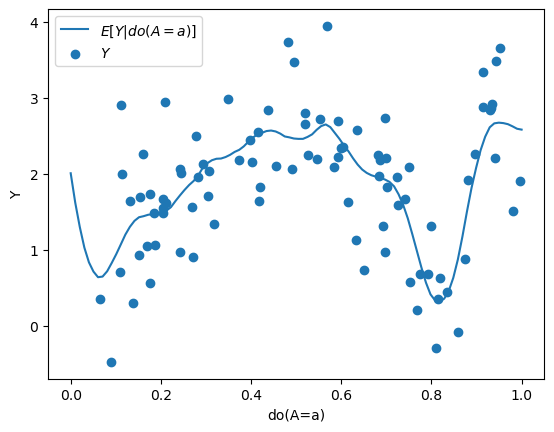

In [25]:
# Dataset generation and plotting E[Y|do(A)]
#torch.random.manual_seed(1), d=4, noise_var = 0.5 # BASE SETTINGS
A,V,Y,doA, YdoA, EYdoA =  Abelation(train_samples, test_samples, d, noise_variance, doAlower, doAupper, mc_samples_EYdoZ,seed = 0)
Y = -Y + 2
EYdoA = -EYdoA + 2

amin = 0.05
inds = (A>=amin)[:,0]
A,V,Y = A[inds], V[inds], Y[inds]
# Plot
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A=a)]$")
plt.scatter(A,Y, label = r"$Y$")
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.legend()
plt.show()

# causalKLGP

In [26]:
"""Initialising model"""
model = causalKLGP(Kernel_A = GaussianKernel, 
                   Kernel_V = GaussianKernel, 
                   dim_A = A.size()[1], 
                   dim_V = V.size()[1], 
                   samples = 10**5)

""" Calibrating model """
niter = 500
learn_rate = 0.1
cal_latent = True
traincalmodel = False

nulist = 2**torch.linspace(-5,5,11)
levels = torch.tensor([0.1,0.3,0.5,0.7,0.9])

In [27]:
""" Training full model """
model.train(Y,A,V,niter,learn_rate)

iter 0 P(Y|V) loss:  tensor(101.7073)
iter 100 P(Y|V) loss:  tensor(13.1537)
iter 200 P(Y|V) loss:  tensor(11.0760)
iter 300 P(Y|V) loss:  tensor(10.2627)
iter 400 P(Y|V) loss:  tensor(9.8321)
iter 0 P(V|A) loss:  tensor(-131.9051)
iter 100 P(V|A) loss:  tensor(-173.2722)
iter 200 P(V|A) loss:  tensor(-174.0749)
iter 300 P(V|A) loss:  tensor(-174.0743)
iter 400 P(V|A) loss:  tensor(-174.0733)


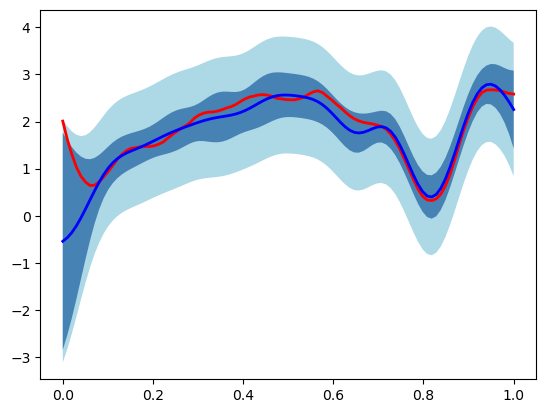

In [28]:
# getting post mean predictions
causalklgp = deepcopy(model)
causalklgp_mu = causalklgp.post_mean(Y, A, V, doA).detach()
causalklgp_var = causalklgp.post_var(Y, A, V,doA, reg = 1e-4, latent = True, nu =1).detach()
causalklgp_var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-4, latent = False, nu = 1).detach()

# Getting CI
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
Upper = (causalklgp_mu[indices]+z_val*torch.sqrt(causalklgp_var[indices]))
Lower = (causalklgp_mu[indices]-z_val*torch.sqrt(causalklgp_var[indices]))
Upper_noise = (causalklgp_mu[indices]+z_val*torch.sqrt(causalklgp_var_noise[indices]))
Lower_noise = (causalklgp_mu[indices]-z_val*torch.sqrt(causalklgp_var_noise[indices]))

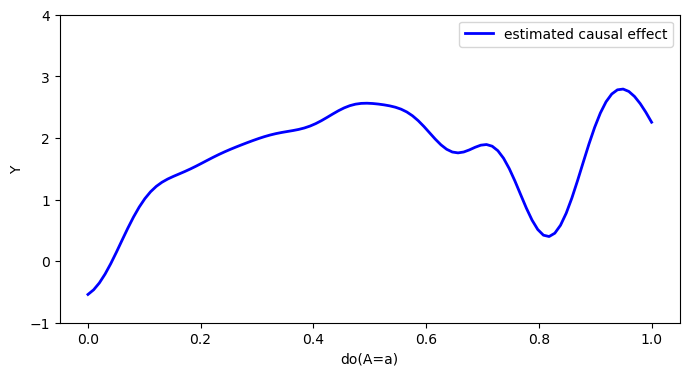

In [79]:
fig,axs = plt.subplots(figsize = (8,4))
plt.plot(doA[indices],causalklgp_mu[indices], label = r"estimated causal effect", color = "blue", linewidth = 2)
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.ylim(-1,4)
plt.legend()
plt.savefig("example_cate_plot1", bbox_inches = "tight")
#plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "black", linewidth = 2)
#plt.fill_between(doA[indices][:,0],Upper_noise[:,0],Lower_noise[:,0], color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
#plt.fill_between(doA[indices][:,0],Upper[:,0],Lower[:,0], color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")

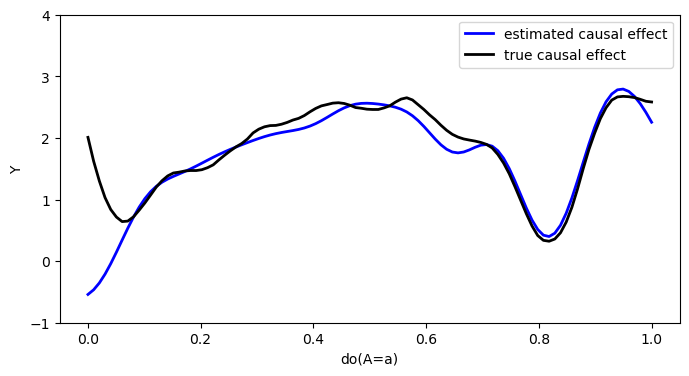

In [80]:
fig,axs = plt.subplots(figsize = (8,4))
plt.plot(doA[indices],causalklgp_mu[indices], label = r"estimated causal effect", color = "blue", linewidth = 2)
plt.plot(doA[indices],EYdoA[indices], label = r"true causal effect", color = "black", linewidth = 2)
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.ylim(-1,4)
plt.legend()
plt.savefig("example_cate_plot2", bbox_inches = "tight")

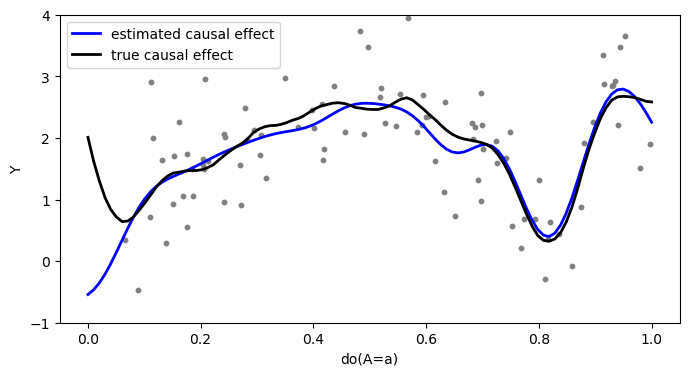

In [81]:
fig,axs = plt.subplots(figsize = (8,4))
plt.plot(doA[indices],causalklgp_mu[indices], label = r"estimated causal effect", color = "blue", linewidth = 2)
plt.plot(doA[indices],EYdoA[indices], label = r"true causal effect", color = "black", linewidth = 2)
plt.scatter(A,Y, color = "grey", s = 10)
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.ylim(-1,4)
plt.legend()
plt.savefig("example_cate_plot3", bbox_inches = "tight")

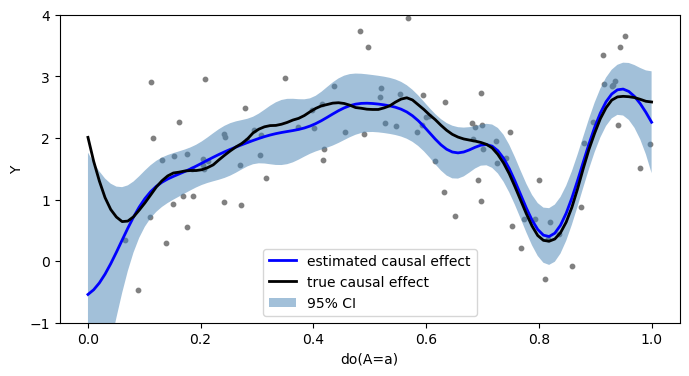

In [82]:
fig,axs = plt.subplots(figsize = (8,4))
plt.plot(doA[indices],causalklgp_mu[indices], label = r"estimated causal effect", color = "blue", linewidth = 2)
plt.plot(doA[indices],EYdoA[indices], label = r"true causal effect", color = "black", linewidth = 2)
plt.scatter(A,Y, color = "grey", s = 10)
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.fill_between(doA[indices][:,0],Upper[:,0],Lower[:,0], color = "steelblue",alpha=0.5, edgecolor='none', label = "95% CI")
plt.ylim(-1,4)
plt.legend()
plt.savefig("example_cate_plot4", bbox_inches = "tight")

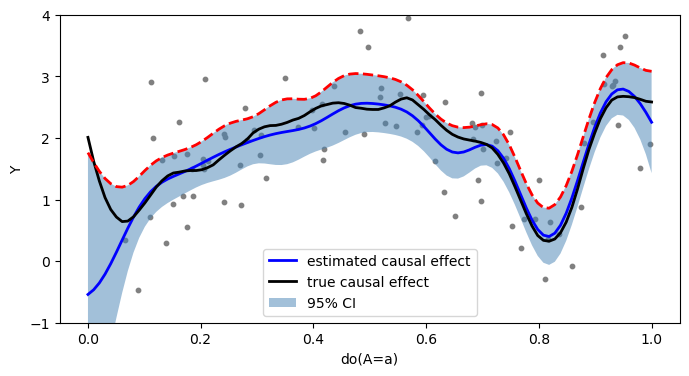

In [83]:
fig,axs = plt.subplots(figsize = (8,4))
plt.plot(doA[indices],causalklgp_mu[indices], label = r"estimated causal effect", color = "blue", linewidth = 2)
plt.plot(doA[indices],EYdoA[indices], label = r"true causal effect", color = "black", linewidth = 2)
plt.scatter(A,Y, color = "grey", s = 10)
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.fill_between(doA[indices][:,0],Upper[:,0],Lower[:,0], color = "steelblue",alpha=0.5, edgecolor='none', label = "95% CI")
plt.plot(doA[indices],Upper[:,0], color = "red", linewidth = 2, ls = "dashed")
plt.ylim(-1,4)
plt.legend()
plt.savefig("example_cate_plot5", bbox_inches = "tight")